## Retail Customer Clustering

### Overview
The dataset given is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts.

### Business Goal
We aim to segment the Customers based on RFM so that the company can target its customers efficiently.

The RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.

### Data

You are given a dataset: each row represents a transaction (so, if a given customer buys a t-shirt and socks you will have one row for the t-shirt and one row for the socks).

+ InvoiceNo: id of the invoice
+ StockCode: id of the given clothing
+ Description: description of the clothing item
+ Quantity: quantity purchased
+ InvoiceDate: date of the purchase
+ UnitPrice: unit price of the clothing item
+ CustomerID: id of the customer
+ Country: country of the customer


You are asked to **develop a clustering algorithm** to be able to group clients based on their RFM:

+ Recency: days from their last purchase
+ Frecuency: how many times per month/week they buy
+ Monetary: how much is their average ticket

### Business questions

1. **How many groups of customers do we have** 
2. **Which is their profile**


### Steps

You can follow those **steps** :
1. *Explore* and understand the dataset. 
2. Data Cleansing
3. Data preparation (RFM)
4. Assess number of clusters
5. Build clusters
6. Profiling of each cluster: how often they buy, how much, are them a high value group or a low value?

In [64]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
import seaborn as sns
import datetime as dt

#for scaling
from sklearn.preprocessing import StandardScaler

#for plotting
#correlations matrix
import seaborn as sns 

#MODEL
from sklearn.cluster import KMeans


In [65]:
#loading data
df = pd.read_csv('retail_data.csv')
df_copy = df.copy()

### Defining Functions and config vars

In [66]:

def check_outliers_IQM(df, vars_without_outliers):
  """Finds outliers with interquartile methodIt gets the df and a list of variables that dont 
  have outliers (categorical and binary vars) and returns a dictionary with the total number of outliers
  and the index of them for each var that HAS outliers
  """
  outliers = dict()
  for column in df.columns:
    if column in vars_without_outliers:
      continue
    else:
      q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)

      IQR = q75 - q25
      lower,upper = q25 - IQR*1.5, q75 + IQR*1.5
      outliers_index = ((df[column] < lower) | (df[column] > upper))

      if len(outliers_index == True) == 0:
        continue
      else:
        output = {
            "indexes" : outliers_index,
            "quantity" : outliers_index.sum(axis = 0)
        }
        outliers[column] = output
  return outliers

def check_outliers_std_dev(df, vars_without_outliers):
  df_no_out = df.copy()
  """Finds outliers with std dev method.It gets the df and a list of variables that dont 
  have outliers (categorical and binary vars) and returns a dictionary with the total number of outliers
  and the index of them for each var that HAS outliers
  """
  outliers = dict()
  for column in df.columns:
    if column in vars_without_outliers:
      continue
    else:
      mean = np.mean(df_no_out[column], axis=0)
      sd = np.std(df_no_out[column], axis=0)

      
      lower,upper =  mean - 3 * sd,  mean + 3 * sd
      outliers_index = (df_no_out[column] < lower) | (df_no_out[column] > upper)
      df_no_out = df_no_out[~outliers_index]
      if len(outliers_index == True) == 0:
        continue
      else:
        output = {
            "indexes" : outliers_index,
            "quantity" : outliers_index.sum(axis = 0)
        }
        outliers[column] = output
  return outliers, df_no_out

def outliers_printer(df, vars_list):
  i=1
  plt.figure(figsize = (20,10))
  for col in vars_list:
   
    plt.subplot(3,3,i)
    sns.boxplot(df[col])

    i=i+1

def careful_standardization(df, not_standardize_list):
  """ This function receives the DataFrame and a list of variables not to standardize
  (for example the target, binary variables, or dummy variables(categorical vars
  should have been dummified). Also can receive sub strings of dummified categorical vars.
  For example, neigborhoodcode when dummified turns into neigborhoodcode_1, neigborhoodcode_2...
  so by putting the string 'neigborhoodcode_' inside the list no dummy of 'neigborhoodcode_' will
  be standardized). The output is the same DataFrame with all the other columns standardized. 
  """
  standardize_vars_cols = []
  dummy_vars_and_y = []

  for column in df.columns:
    for element in not_standardize_list:
    
      if element in column:
        save = False
        break
      else:
        save = True

    if save:
      standardize_vars_cols.append(column)
    else:
      dummy_vars_and_y.append(column)

  # scaler
  scaler = StandardScaler().fit(df[standardize_vars_cols])
  scaled_features = scaler.transform(df[standardize_vars_cols])
  df_scaled = pd.DataFrame(scaled_features, index = df.index, columns = df[standardize_vars_cols].columns)
  df_scaled[dummy_vars_and_y] = df[dummy_vars_and_y]

  return df_scaled

In [67]:
#vars

# Exploring and Understanding the DataSet

In [68]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [70]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [71]:
#checking outliers
cat_and_binaries = df.columns.drop(["Quantity", "UnitPrice"])
outliers = check_outliers_std_dev(df, cat_and_binaries)[0]


/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


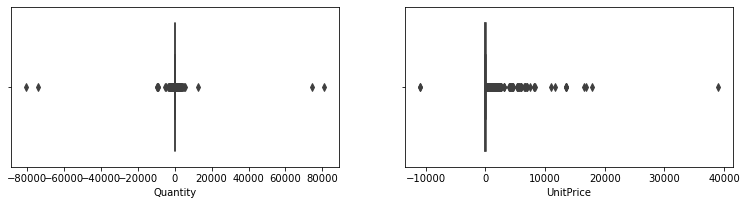

In [72]:
#printing outliers
outliers_printer(df_copy, outliers.keys())

There are some negative values for quantity and also UnitPrice. There are also values of 0 for UnitPrice and Quantity. The values equal to 0 have to be eliminated as they don't give any information. Negative values of UnitPrice will also be deleted as they don't make any sense. Negative values of Quantity will be left for reasons that will be commented afterwards.

In [73]:
df_copy = df_copy.drop(df_copy[df_copy["UnitPrice"]<= 0].index)
df_copy = df_copy.drop(df_copy[df_copy["Quantity"]== 0].index)

In [74]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539392 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    539392 non-null  object 
 1   StockCode    539392 non-null  object 
 2   Description  539392 non-null  object 
 3   Quantity     539392 non-null  int64  
 4   InvoiceDate  539392 non-null  object 
 5   UnitPrice    539392 non-null  float64
 6   CustomerID   406789 non-null  float64
 7   Country      539392 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 53.2+ MB


In [75]:
#filling NA values
df_copy['CustomerID'].fillna(method ='pad',inplace=True)  

In [76]:
df_copy.groupby(['CustomerID','InvoiceNo'])['Quantity'].sum()

CustomerID  InvoiceNo
12346.0     541431       74215
            C541433     -74215
12347.0     537626         319
            542237         315
            549222         483
                         ...  
18283.0     579673         134
            580872         142
18287.0     554065         488
            570715         990
            573167         108
Name: Quantity, Length: 23796, dtype: int64

Here in the first line we can see that the negative values may represent refunds. For this reason negative values of Quantity have not been deleted

In [77]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539392 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    539392 non-null  object 
 1   StockCode    539392 non-null  object 
 2   Description  539392 non-null  object 
 3   Quantity     539392 non-null  int64  
 4   InvoiceDate  539392 non-null  object 
 5   UnitPrice    539392 non-null  float64
 6   CustomerID   539392 non-null  float64
 7   Country      539392 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 53.2+ MB


In [78]:
# we delete any NaN value left to clean the data
df_copy.dropna(how = "any")
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539392 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    539392 non-null  object 
 1   StockCode    539392 non-null  object 
 2   Description  539392 non-null  object 
 3   Quantity     539392 non-null  int64  
 4   InvoiceDate  539392 non-null  object 
 5   UnitPrice    539392 non-null  float64
 6   CustomerID   539392 non-null  float64
 7   Country      539392 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 53.2+ MB


## Data Preparation

You are asked to **develop a clustering algorithm** to be able to group clients based on their RFM:

+ Recency: days from their last purchase
+ Frecuency: how many times per month/week they buy
+ Monetary: how much is their average ticket

In [79]:
df_copy["CustomerID"] = df_copy["CustomerID"].astype(str)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539392 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    539392 non-null  object 
 1   StockCode    539392 non-null  object 
 2   Description  539392 non-null  object 
 3   Quantity     539392 non-null  int64  
 4   InvoiceDate  539392 non-null  object 
 5   UnitPrice    539392 non-null  float64
 6   CustomerID   539392 non-null  object 
 7   Country      539392 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 53.2+ MB


In [80]:
df_copy["Total"] = df_copy["Quantity"] * df_copy["UnitPrice"]


In [81]:
# Creating the dataset that will contain all the data to group clients
# Adding the average ticket
avgTicket = pd.DataFrame(data = df_copy.groupby('CustomerID', as_index = False)["Total"].mean())
avgTicket.columns = ["CustomerID", "AvgTicket"]
avgTicket.head()

,CustomerID,AvgTicket
0,12346.0,0.000000
1,12347.0,23.681319
2,12348.0,16.341117
3,12349.0,24.076027
4,12350.0,19.670588


In [82]:
avgTicket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4371 entries, 0 to 4370
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4371 non-null   object 
 1   AvgTicket   4371 non-null   float64
dtypes: float64(1), object(1)
memory usage: 102.4+ KB


In [83]:
# Adding frequency
freq = pd.DataFrame(data = df_copy.groupby('CustomerID', as_index = False)['InvoiceNo'].count())
freq.columns = ["CustomerID", "Frequency"]
freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,206
3,12349.0,73
4,12350.0,17


In [84]:
# Adding Recency
# Convert to datetime to proper datatype

df_copy['InvoiceDate'] = pd.to_datetime(df_copy['InvoiceDate'],format='%d-%m-%Y %H:%M')
df_copy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [85]:
# Compute the maximum date to know the last transaction date

max_date = max(df_copy['InvoiceDate'])
max_date


Timestamp('2011-12-09 12:50:00')

In [86]:

# Compute the difference between max date and transaction date

df_copy['Diff'] = max_date - df_copy['InvoiceDate']
df_copy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [87]:
# Compute last transaction date to get the recency of customers

recency = df_copy.groupby('CustomerID')['Diff'].min().dt.days
recency = recency.reset_index()
recency.columns = ['CustomerID', 'Recency']
recency.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [88]:
final = pd.merge(avgTicket, freq, on='CustomerID', how='inner')

final = pd.merge(final, recency, on='CustomerID', how='inner')
final.head()

,CustomerID,AvgTicket,Frequency,Recency
0,12346.0,0.000000,2,325
1,12347.0,23.681319,182,1
2,12348.0,16.341117,206,74
3,12349.0,24.076027,73,18
4,12350.0,19.670588,17,309


In [89]:
final[final["AvgTicket"]<0]

,CustomerID,AvgTicket,Frequency,Recency
18,12365.0,-9.329556e+00,45,290
125,12503.0,-1.126000e+03,1,337
127,12505.0,-4.500000e+00,1,300
212,12605.0,-2.500000e+00,3,364
264,12666.0,-1.137200e+02,2,358
...,...,...,...,...
4145,17975.0,-5.170602e+00,299,14
4168,18010.0,-1.022438e+01,16,256
4209,18072.0,-1.529641e-15,36,154
4260,18141.0,-3.540000e+01,1,360


In [90]:
final = final.drop(final[final["AvgTicket"]<0].index)

In [91]:
final[final["AvgTicket"]<0]

,CustomerID,AvgTicket,Frequency,Recency


In [92]:
final[final["Frequency"]<0]

,CustomerID,AvgTicket,Frequency,Recency


In [93]:
final[final["Recency"]<0]

,CustomerID,AvgTicket,Frequency,Recency


/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

The number of outliers for each varaible are: 
AvgTicket: 37
Frequency: 44
Recency: 0


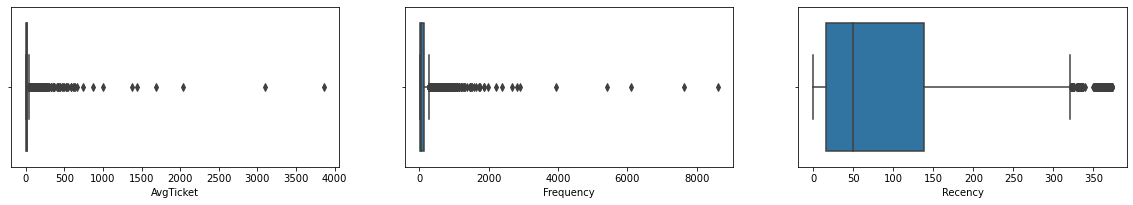

In [94]:
outliers = check_outliers_std_dev(final, ["CustomerID"])[0]
outliers_printer(final, outliers.keys())

print("The number of outliers for each varaible are: ")
for value in outliers.keys():
    print(value + ": " + str(outliers[value]["quantity"]))


In [95]:
#remove outliers

final_no_outliers = check_outliers_std_dev(final, ["CustomerID"])[1]
final_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4370
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4226 non-null   object 
 1   AvgTicket   4226 non-null   float64
 2   Frequency   4226 non-null   int64  
 3   Recency     4226 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 165.1+ KB


In [97]:
final_no_outliers

,CustomerID,AvgTicket,Frequency,Recency
0,12346.0,0.000000,2,325
1,12347.0,23.681319,182,1
2,12348.0,16.341117,206,74
3,12349.0,24.076027,73,18
4,12350.0,19.670588,17,309
...,...,...,...,...
4366,18280.0,25.632523,325,277
4367,18281.0,11.545714,7,180
4368,18282.0,13.584615,13,7
4369,18283.0,2.771005,756,3


In [103]:
final_no_outliers = final_no_outliers.drop(final_no_outliers[final_no_outliers["AvgTicket"] == 0].index)
final_no_outliers = final_no_outliers.drop(final_no_outliers[final_no_outliers["Recency"] == 0].index)
final_no_outliers = final_no_outliers.drop(final_no_outliers[final_no_outliers["Frequency"] == 0].index)
final_no_outliers

,CustomerID,AvgTicket,Frequency,Recency,log_Avg,log_Rec,log_Freq
1,12347.0,23.681319,182,1,3.164686,0.000000,5.204007
2,12348.0,16.341117,206,74,2.793684,4.304065,5.327876
3,12349.0,24.076027,73,18,3.181217,2.890372,4.290459
4,12350.0,19.670588,17,309,2.979125,5.733341,2.833213
5,12352.0,12.862471,255,35,2.554314,3.555348,5.541264
...,...,...,...,...,...,...,...
4366,18280.0,25.632523,325,277,3.243862,5.624018,5.783825
4367,18281.0,11.545714,7,180,2.446314,5.192957,1.945910
4368,18282.0,13.584615,13,7,2.608938,1.945910,2.564949
4369,18283.0,2.771005,756,3,1.019210,1.098612,6.628041


In [104]:
final_no_outliers["log_Avg"] = np.log(final_no_outliers["AvgTicket"])
final_no_outliers["log_Rec"] = np.log(final_no_outliers["Recency"])
final_no_outliers["log_Freq"] = np.log(final_no_outliers["Frequency"])

## Scaling data

In [105]:
final_scaled = careful_standardization(final_no_outliers, ["CustomerID"])
final_scaled

,AvgTicket,Frequency,Recency,log_Avg,log_Rec,log_Freq,CustomerID
1,0.010447,0.530821,-0.915610,0.293881,-2.600437,1.037708,12347.0
2,-0.231118,0.690499,-0.179776,0.027330,0.382130,1.129708,12348.0
3,0.023437,-0.194383,-0.744252,0.305758,-0.597510,0.359200,12349.0
4,-0.121545,-0.566964,2.189003,0.160562,1.372569,-0.723123,12350.0
5,-0.345599,1.016508,-0.572893,-0.144649,-0.136705,1.288194,12352.0
...,...,...,...,...,...,...,...
4366,0.074661,1.482235,1.866446,0.350766,1.296812,1.468349,18280.0
4367,-0.388934,-0.633497,0.888695,-0.222242,0.998101,-1.382139,18281.0
4368,-0.321834,-0.593577,-0.855131,-0.105403,-1.251989,-0.922368,18282.0
4369,-0.677708,4.349784,-0.895450,-1.247564,-1.839137,2.095364,18283.0


## Working the model

In [117]:
#First we will take the CustomerID from the data as it does not add any information to understand the clusters of customers

X = final_scaled[final_scaled.columns.drop("CustomerID")]
X = X[["log_Avg", "log_Rec", "log_Freq"]]
X

,log_Avg,log_Rec,log_Freq
1,0.293881,-2.600437,1.037708
2,0.027330,0.382130,1.129708
3,0.305758,-0.597510,0.359200
4,0.160562,1.372569,-0.723123
5,-0.144649,-0.136705,1.288194
...,...,...,...
4366,0.350766,1.296812,1.468349
4367,-0.222242,0.998101,-1.382139
4368,-0.105403,-1.251989,-0.922368
4369,-1.247564,-1.839137,2.095364


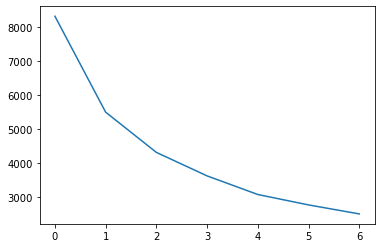

In [118]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [132]:
#creating the model
model_kmeans = KMeans(n_clusters=2, max_iter=50)
y_clusters = model_kmeans.fit_predict(X)
y_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

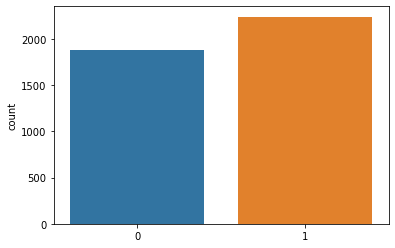

In [133]:
sns.countplot(y_clusters)

In [134]:
model_kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [135]:
x = X.values

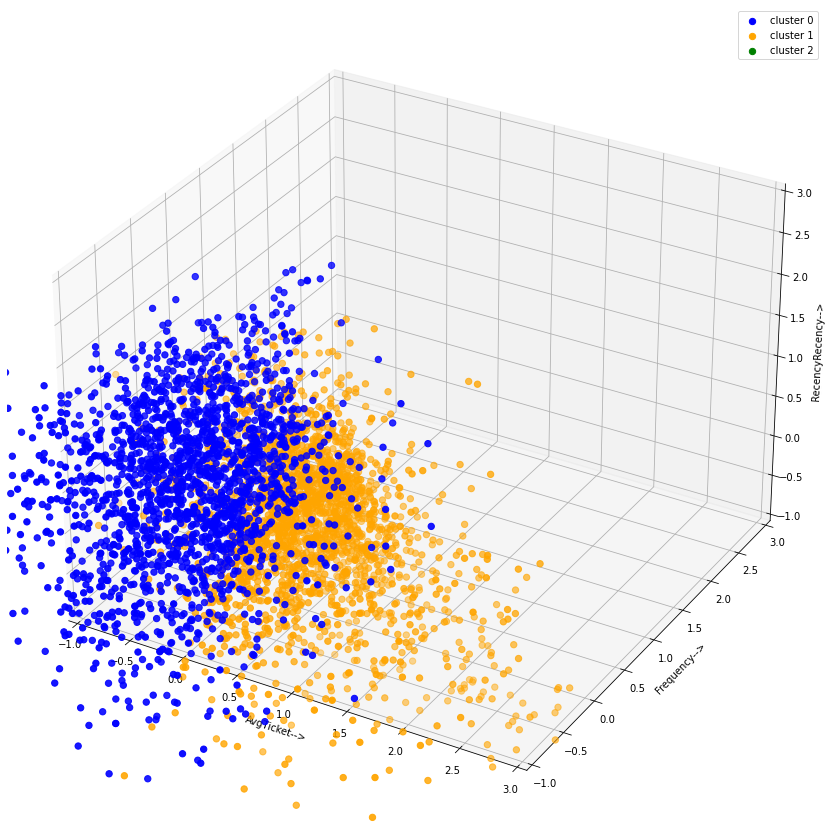

In [136]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.set_xlabel('AvgTicket-->')
ax.set_ylabel('Frequency-->')
ax.set_zlabel('RecencyRecency-->')


ax.axes.set_xlim3d(left=-1, right=3) 
ax.axes.set_ylim3d(bottom=-1, top=3) 
ax.axes.set_zlim3d(bottom=-1, top=3)
ax.legend()
plt.show()